In [7]:
!cp /content/drive/MyDrive/DATASETS/cartoon_data/cartoonset100k.tgz /content/

In [ ]:
!tar -xvzf /content/cartoonset100k.tgz

In [116]:
!rm cartoonset100k/0/*.csv
!rm cartoonset100k/1/*.csv
!rm cartoonset100k/2/*.csv
!rm cartoonset100k/3/*.csv
!rm cartoonset100k/4/*.csv
!rm cartoonset100k/5/*.csv
!rm cartoonset100k/6/*.csv
!rm cartoonset100k/7/*.csv
!rm cartoonset100k/8/*.csv
!rm cartoonset100k/9/*.csv
!rm cartoonset100k.tgz

rm: cannot remove 'cartoonset100k/0/*.csv': No such file or directory
rm: cannot remove 'cartoonset100k.tgz': No such file or directory


In [1]:
import os, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

In [2]:
IMAGE_CHANNELS = 3
GENERATE_RESOLUTION_FACTOR = 3
GENERATE_SQUARE = 32 * GENERATE_RESOLUTION_FACTOR

PREVIEW_ROWS, PREVIEW_COLS = 4, 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100

# Model configuration
DATA_PATH = '/content/'
FOLDER_NAME = 'cartoonset100k'

EPOCHS = 50
BATCH_SIZE = 128
BUFFER_SIZE = 61000

print(f"Image details: {GENERATE_SQUARE}px")

Image details: 96px


In [3]:
# Convert seconds to HH:MM:SS.MI format
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [4]:
training_binary_path = os.path.join(DATA_PATH, 
    f'training_data_{FOLDER_NAME}_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
print("Binary file name: ", training_binary_path)

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("File not found, loading training images...")

  training_data = np.zeros((10000,96,96,3))
  faces_path = os.path.join(DATA_PATH, FOLDER_NAME)
  faces_path_filenames = os.listdir(faces_path)
  i=0
  for filen in tqdm(faces_path_filenames):
    path1 = os.path.join(faces_path,filen)
    file_dir = os.listdir(path1)
    for filename in file_dir:
        path = os.path.join(path1,filename)
        # print(path)
        # Convert RGBA to RGB format
        try:
          image = cv2.resize(cv2.imread(path),(GENERATE_SQUARE,GENERATE_SQUARE))
          # training_data.append(image/255.0)
          training_data[i,:,:,:] = image/255.0
          i+=1
          # cv2_imshow(image)
          
        except Exception as e:
          # print(f'[Error] image: {image}, exception: {e}')
          pass
  # training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  # training_data= np.array(training_data)
  # training_data = training_data.astype(np.float32)
  # training_data = training_data 


  print("Saving training image binary file...")
  np.save(training_binary_path,training_data)
  stop = time.time()-start
else:
  print("Loading previous training binary file...")
  load_data_start_time = time.time()
  training_data = np.load(training_binary_path)
  load_data_tat = time.time() - load_data_start_time


Binary file name:  /content/training_data_cartoonset100k_96_96.npy
File not found, loading training images...


100%|██████████| 10/10 [06:20<00:00, 38.08s/it]


Saving training image binary file...


In [8]:
!cp /content/training_data_cartoonset100k_96_96.npy /content/drive/MyDrive/DATASETS/cartoon_data/

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print("Length of total images: ", len(training_data))
print("Length of total batches: ", len(train_dataset))
print("Length of images in one batch: ", len(list(train_dataset.as_numpy_iterator())[0]))

Length of total images:  10000
Length of total batches:  79
Length of images in one batch:  128


In [ ]:
from google.colab.patches import cv2_imshow
iad = train_dataset.take(1)
for i in iad:
  print(i[0])
  plt.imshow(i[0].numpy())

In [33]:
def build_generator(seed_size, channels):
  model = Sequential()

  model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Reshape((4, 4, 256)))
  
  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
  assert model.output_shape == (None, 32, 32, 256)
  model.add(BatchNormalization())
  model.add(LeakyReLU())


  model.add(Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='sigmoid'))
  assert model.output_shape == (None, 96, 96, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
  assert model.output_shape == (None, 96, 96, 3)
  
  return model

In [34]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [35]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  # generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  
  fig = plt.figure(figsize=(15,15))
  plt.imshow(im)
  plt.show()
  im.save(filename)

Generated image shape:  (1, 96, 96, 3)


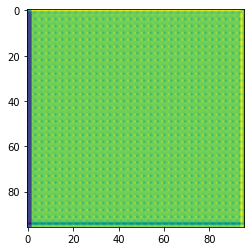

In [36]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
print("Generated image shape: ", generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])

In [37]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50674623]], shape=(1, 1), dtype=float32)


In [38]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [39]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [41]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  # generate_and_save_images(generator, epochs, seed)
  return gen_loss,disc_loss

In [42]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in tqdm(range(epochs)):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    
    display.clear_output(wait=True)
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  display.clear_output(wait=True)
  print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
  save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

Epoch 50, gen loss=2.08372163772583,disc loss=0.7978906035423279, time=0:00:32.43


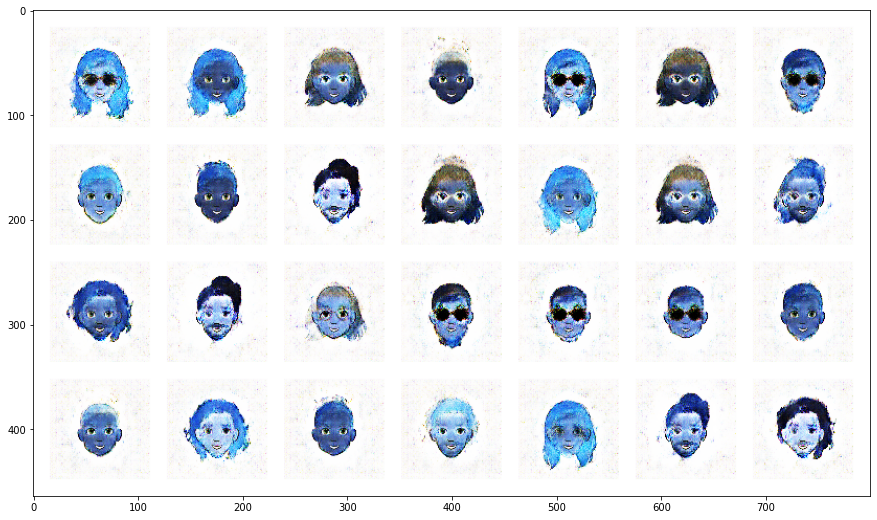

Training time: 0:27:48.81


In [43]:
train(train_dataset, EPOCHS)

In [ ]:
name = f"face_generator_{EPOCHS}.h5"
generator.save(os.path.join(DATA_PATH, name))

In [48]:
fixed_seed = np.random.normal(0, 1, (1,SEED_SIZE))
# save_images(100,fixed_seed)
generated_images = generator.predict(fixed_seed)


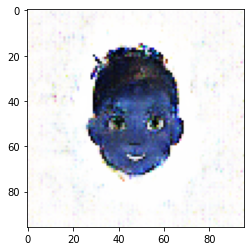

In [50]:
generated_images.shape
plt.imshow(generated_images[0])

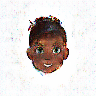

In [52]:
cv2_imshow(generated_images[0]*255)